<a href="https://colab.research.google.com/github/mhmdsirajkhan/Customer_Segmentation_KMeans/blob/main/Stock_Price_LSTM_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance

In [3]:
# Import the necessary libraries
import yfinance as yf
import pandas as pd
import datetime

# Define the ticker symbol and the start date
ticker = 'AAPL'
start_date = datetime.datetime(2015, 1, 1)
end_date = datetime.datetime.now() # Get data up to today

# Fetch the data for Apple (AAPL) using yfinance
df = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows to verify the data was loaded
print("--- DataFrame Head (Data Acquired) ---")
print(df.head())

/tmp/ipython-input-2881856824.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

--- DataFrame Head (Data Acquired) ---
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261047  24.729270  23.821672  24.718174  212818400
2015-01-05  23.577576  24.110152  23.391175  24.030265  257142000
2015-01-06  23.579796  23.839426  23.218087  23.641929  263188400
2015-01-07  23.910433  24.010290  23.677430  23.788384  160423600
2015-01-08  24.829124  24.886821  24.121242  24.238854  237458000


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM # You'll need these

# --- 1. Filter and Scale the Data ---

# Create a new DataFrame with only the 'Close' column (or 'Close' from the multi-level index)
# Adjust the column indexing based on your df structure:
if isinstance(df.columns, pd.MultiIndex):
    data_to_use = df['Close']['AAPL'].values
else:
    data_to_use = df['Close'].values

# Reshape the data for the scaler
dataset = data_to_use.reshape(-1, 1)

# Initialize and fit the scaler (MinMax Scaling to [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# --- 2. Split Data (Sequential Split) ---

# 65% of the data for training, remaining 35% for testing/validation
training_data_len = int(len(scaled_data) * 0.65)
train_data = scaled_data[0:training_data_len, :]

print(f"Total Data Points: {len(scaled_data)}")
print(f"Training Data Length: {training_data_len}")

Total Data Points: 2714
Training Data Length: 1764


In [6]:
# --- 3. Create Training Sequences ---

# Define the timestep window (100 previous days to predict the next day)
time_step = 100

X_train = []
y_train = []

for i in range(time_step, len(train_data)):
    # X_train gets the previous 100 days (the features)
    X_train.append(train_data[i-time_step:i, 0])
    # y_train gets the next day's price (the target)
    y_train.append(train_data[i, 0])

# Convert lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data for the LSTM input layer: [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (1664, 100, 1)
y_train shape: (1664,)


In [7]:
# --- 4. Build the Stacked LSTM Model ---

model = Sequential()
# 1st LSTM Layer: Needs return_sequences=True to feed into the next LSTM
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# 2nd LSTM Layer: Needs return_sequences=True to feed into the next LSTM
model.add(LSTM(50, return_sequences=True))
# 3rd LSTM Layer
model.add(LSTM(50))
# Final Dense Output Layer (Predicts one single price value)
model.add(Dense(1))

# Compile the model (using Mean Squared Error for price prediction)
model.compile(optimizer='adam', loss='mean_squared_error')

# --- 5. Train the Model ---

# Train the model (adjust epochs if training is slow, but 100 is standard)
print("\nStarting Model Training (This may take a few minutes)...")
model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=64, verbose=1)
print("Model Training Complete.")


Starting Model Training (This may take a few minutes)...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 0.0137 - val_loss: 8.1074e-04
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 6.6165e-04 - val_loss: 9.0025e-04
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 2.2956e-04 - val_loss: 6.0169e-04
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - loss: 2.2782e-04 - val_loss: 6.7029e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 2.0018e-04 - val_loss: 6.0409e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 2.1087e-04 - val_loss: 6.4033e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - loss: 1.7480e-04 - val_loss: 6.3866e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 1.9861e-04 - val_loss: 8.5594e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 1.7449e-04 - val_loss: 7.5340e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 1.6555e-04 - val_loss: 4.9379e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 1.

In [11]:
# Flatten the MultiIndex columns by dropping the top level (Price)
df.columns = df.columns.droplevel(0)

In [9]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

In [15]:
# Print column names to confirm they are simple
print(df.columns)

# If the output is: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
# then you know the column name is simply 'Close'.

Index(['AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL'], dtype='object', name='Ticker')


In [17]:
# Re-import yfinance and fetch data cleanly
import yfinance as yf
import datetime
import pandas as pd

ticker = 'AAPL'
start_date = datetime.datetime(2015, 1, 1)

# Fetch data again. The download often returns a MultiIndex.
df = yf.download(ticker, start=start_date)

# --- CRITICAL FIX: FLATTEN MULTI-INDEX BY PROMOTING PRICE NAMES ---
# We assume the default multi-index structure: ('Price Category', 'Ticker')
# We drop the 'Ticker' level (level 1) to get clean price names.
df.columns = df.columns.droplevel(1)

# Display the new columns to confirm the fix
print("--- Confirmed Column Headers ---")
print(df.columns)

/tmp/ipython-input-1634073497.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date)
[*********************100%***********************]  1 of 1 completed

--- Confirmed Column Headers ---
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [18]:
# Run this after confirming the column fix above:

# Filter and Scale the data using the correct 'Close' column
df_close = df.filter(['Close'])
dataset = df_close.values

# Initialize and fit the scaler (MinMax Scaling to [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# --- Continue with Phase B: Sequential Data Splitting and Model Training ---
training_data_len = int(len(scaled_data) * 0.65)
train_data = scaled_data[0:training_data_len, :]

print("\nData successfully scaled. Ready for LSTM sequences.")


Data successfully scaled. Ready for LSTM sequences.


In [19]:
# --- 1. Define Timesteps and Create Sequences ---

# Time step window (100 previous prices to predict the next price)
time_step = 100

X_train = []
y_train = []

# Loop through the training data length
for i in range(time_step, len(train_data)):
    # X_train: gets the previous 100 days of data (the features)
    X_train.append(train_data[i-time_step:i, 0])
    # y_train: gets the next day's price (the target)
    y_train.append(train_data[i, 0])

# Convert lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data for the LSTM input layer: [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(f"X_train shape (samples, timesteps, features): {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape (samples, timesteps, features): (1664, 100, 1)
y_train shape: (1664,)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# --- 2. Build the Stacked LSTM Model ---

model = Sequential()
# 1st LSTM Layer: Use return_sequences=True to feed output to the next LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# Optional: Add Dropout to prevent overfitting
model.add(Dropout(0.2))

# 2nd LSTM Layer: Still feeds into another LSTM
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

# 3rd LSTM Layer: Final LSTM layer (return_sequences=False is default/optional)
model.add(LSTM(50))
model.add(Dropout(0.2))

# Final Dense Output Layer (Predicts one single price value)
model.add(Dense(1))

# Compile and Train the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model (Using 100 epochs as suggested in the resource)
print("\nStarting Model Training...")
# We use a small validation_split to track loss performance
model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=64)
print("Model Training Complete.")


Starting Model Training...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - loss: 0.0139 - val_loss: 0.0012
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0010 - val_loss: 6.9422e-04
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 7.4579e-04 - val_loss: 9.8294e-04
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 5.7391e-04 - val_loss: 0.0014
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 5.0040e-04 - val_loss: 0.0015
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 5.0055e-04 - val_loss: 0.0017
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 4.9637e-04 - val_loss: 0.0018
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 4.0215e-04 - val_loss: 0.0020
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 4.7712e-04 - val_loss: 0.0011
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 6.1371e-04 - val_loss: 7.9051e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 4.1001e-04 - val_loss: 9.0656e-04


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


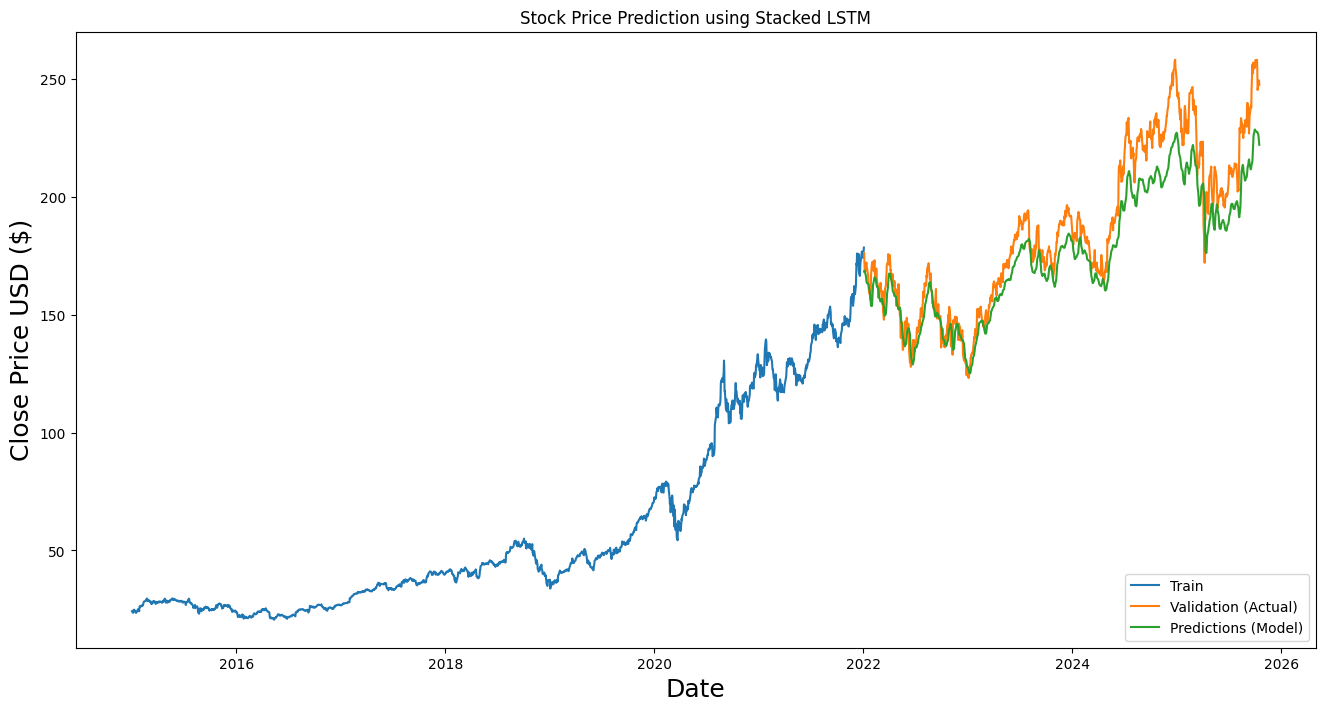


--- Model Evaluation (Last 5 Actual vs. Predicted Prices) ---
                 Close  Predictions
Date                               
2025-10-10  245.270004   227.228134
2025-10-13  247.660004   226.143753
2025-10-14  247.770004   224.639587
2025-10-15  249.339996   223.124634
2025-10-16  247.449997   222.015350


In [21]:
# --- 3. Prepare Test Data and Predict ---

# Get the test set data (need time_step history for the first prediction point)
test_data = scaled_data[training_data_len - time_step:, :]

X_test = []
# y_test are the actual dollar prices for comparison (the unscaled data)
y_test = dataset[training_data_len:, :]

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Generate predictions
predictions = model.predict(X_test)

# Inverse Transform the predictions to get actual dollar values
predictions = scaler.inverse_transform(predictions)

# --- 4. Plotting the Results ---

# Separate the original data into train and test sections for plotting
train = df.iloc[:training_data_len]['Close']
valid = df.iloc[training_data_len:]['Close']

# Create a DataFrame for validation data and add predictions for plotting
valid_plot = pd.DataFrame(valid)
valid_plot['Predictions'] = predictions

# Visualize the results
plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction using Stacked LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train, label='Training Data') # Plot training history
plt.plot(valid_plot[['Close', 'Predictions']]) # Plot actual vs predicted on test set
plt.legend(['Train', 'Validation (Actual)', 'Predictions (Model)'], loc='lower right')
plt.show()

# Print the final result verification
print("\n--- Model Evaluation (Last 5 Actual vs. Predicted Prices) ---")
print(valid_plot[['Close', 'Predictions']].tail())